In [1]:
!pip install quimb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 65.8 MB/s eta 0:00:00


--- Starting Validation Run (N=4) ---
QTN Solver Wall-Clock Time: 0.6184 seconds
Classical Solver Wall-Clock Time: 0.0202 seconds

L2 Error between solvers: 0.000249


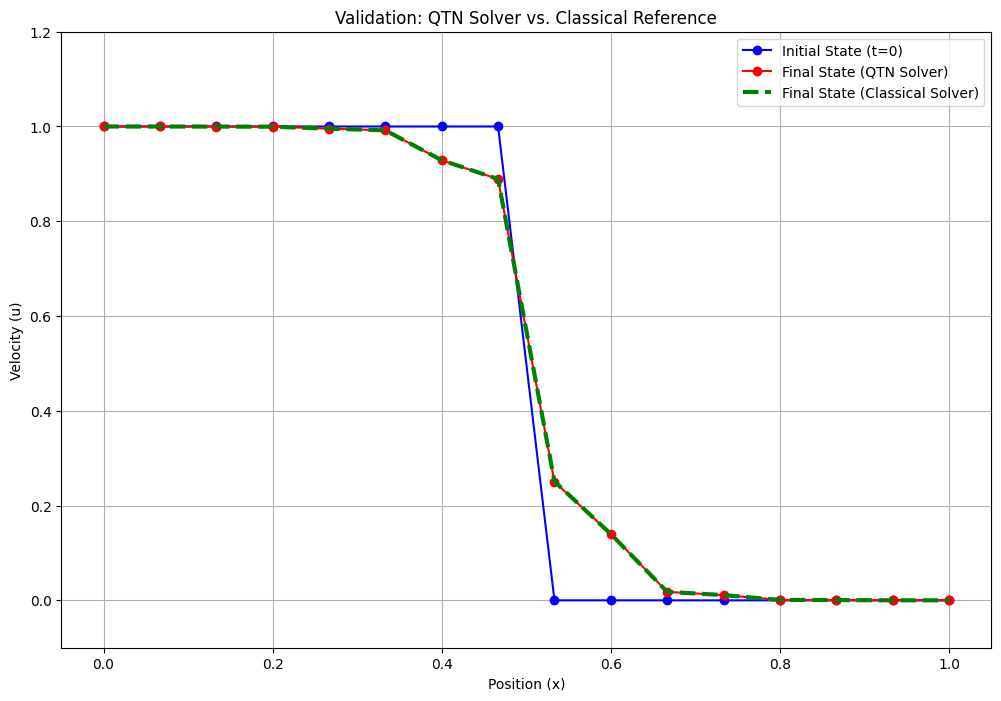


--- Starting Benchmark Run ---

Running for N = 4 (16 grid points)...
  QTN Solver Time: 0.7159s
  Classical Solver Time: 0.0264s

Running for N = 6 (64 grid points)...
  QTN Solver Time: 1.0943s
  Classical Solver Time: 0.0346s

Running for N = 8 (256 grid points)...
  QTN Solver Time: 1.4396s
  Classical Solver Time: 0.0903s

Running for N = 10 (1024 grid points)...


/tmp/ipython-input-309183249.py:47: RuntimeWarning: overflow encountered in multiply
  rhs_vector = -u_vector * du_dx_convection + viscosity * d2u_dx2_diffusion
/usr/local/lib/python3.11/dist-packages/quimb/tensor/decomp.py:363: UserWarning: Got: Array must not contain infs or NaNs., falling back to scipy gesvd driver.
  warnings.warn(f"Got: {e}, falling back to scipy gesvd driver.")


ValueError: array must not contain infs or NaNs

In [2]:
# ============== Part 1: Imports and Setup ==============
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import matplotlib.pyplot as plt
import time

# ============== Part 2: The Quantum-Inspired (QTN) Solver ==============
# This is the logic from our 'qtn_solver.py' file.

def run_qtn_simulation(n_qubits=4, n_steps=500, plot_result=True):
    """
    Solves the 1D Burgers' equation using the quantum-inspired tensor network method.
    """
    # --- Setup ---
    grid_points = 2**n_qubits
    x_min, x_max = 0.0, 1.0
    x_grid = np.linspace(x_min, x_max, grid_points)
    dx = (x_max - x_min) / (grid_points - 1)
    viscosity = 0.03
    dt = 0.0002
    max_bond_dim = 16

    # --- MPS Helper Functions ---
    def vector_to_mps(vector, n_qubits, max_bond_dim):
        dims = [2] * n_qubits
        mps = qtn.MatrixProductState.from_dense(vector.reshape(dims), dims=dims)
        mps.compress(max_bond=max_bond_dim)
        return mps

    def mps_to_vector(mps):
        return mps.to_dense().flatten()

    # --- Initialization ---
    u_initial_vector = np.zeros(grid_points)
    u_initial_vector[x_grid <= 0.5] = 1.0
    u_mps = vector_to_mps(u_initial_vector, n_qubits, max_bond_dim)

    # --- Time evolution loop ---
    start_time = time.time()
    for step in range(n_steps):
        u_vector = mps_to_vector(u_mps)
        du_dx_convection = np.zeros_like(u_vector)
        for i in range(1, len(u_vector)):
            du_dx_convection[i] = (u_vector[i] - u_vector[i-1]) / dx
        d2u_dx2_diffusion = np.gradient(np.gradient(u_vector, dx), dx)
        rhs_vector = -u_vector * du_dx_convection + viscosity * d2u_dx2_diffusion
        u_next_vector = u_vector + dt * rhs_vector
        u_mps = vector_to_mps(u_next_vector, n_qubits, max_bond_dim)
    end_time = time.time()
    wall_clock_time = end_time - start_time

    u_final_vector = mps_to_vector(u_mps)

    if plot_result:
        plt.figure(figsize=(12, 7))
        plt.plot(x_grid, u_initial_vector, 'bo-', label='Initial State (t=0)')
        plt.plot(x_grid, u_final_vector, 'ro-', label=f'Final State (QTN, t={n_steps*dt:.2f}s)')
        plt.title("1D Burgers' Equation - QTN Solver")
        plt.xlabel("Position (x)"), plt.ylabel("Velocity (u)"), plt.grid(True), plt.legend(), plt.ylim(-0.1, 1.2)
        plt.show()

    return u_initial_vector, u_final_vector, wall_clock_time

# ============== Part 3: The Classical Reference Solver ==============
# This is the logic from our 'classical_solver.py' file.

def run_classical_simulation(n_qubits=4, n_steps=500, plot_result=True):
    """
    Solves the 1D Burgers' equation using a standard finite difference method.
    """
    # --- Setup ---
    grid_points = 2**n_qubits
    x_min, x_max = 0.0, 1.0
    x_grid = np.linspace(x_min, x_max, grid_points)
    dx = (x_max - x_min) / (grid_points - 1)
    viscosity = 0.03
    dt = 0.0002

    # --- Initialization ---
    u_vector = np.zeros(grid_points)
    u_vector[x_grid <= 0.5] = 1.0
    u_initial_vector = u_vector.copy()

    # --- Time evolution loop ---
    start_time = time.time()
    for step in range(n_steps):
        du_dx_convection = np.zeros_like(u_vector)
        for i in range(1, len(u_vector)):
            du_dx_convection[i] = (u_vector[i] - u_vector[i-1]) / dx
        d2u_dx2_diffusion = np.gradient(np.gradient(u_vector, dx), dx)
        rhs = -u_vector * du_dx_convection + viscosity * d2u_dx2_diffusion
        u_vector = u_vector + dt * rhs
    end_time = time.time()
    wall_clock_time = end_time - start_time

    if plot_result:
        plt.figure(figsize=(12, 7))
        plt.plot(x_grid, u_initial_vector, 'bo-', label='Initial State (t=0)')
        plt.plot(x_grid, u_vector, 'go-', label=f'Final State (Classical, t={n_steps*dt:.2f}s)')
        plt.title("1D Burgers' Equation - Classical Reference Solver")
        plt.xlabel("Position (x)"), plt.ylabel("Velocity (u)"), plt.grid(True), plt.legend(), plt.ylim(-0.1, 1.2)
        plt.show()

    return u_initial_vector, u_vector, wall_clock_time

# ============== Part 4: The Validation and Benchmark Script ==============
# This is the logic from our 'validation_benchmark.py' file.

def validate_solvers():
    """
    Runs both solvers for N=4 and compares their final results for accuracy.
    """
    print("--- Starting Validation Run (N=4) ---")
    qtn_initial, qtn_final, qtn_time = run_qtn_simulation(n_qubits=4, plot_result=False)
    print(f"QTN Solver Wall-Clock Time: {qtn_time:.4f} seconds")
    classical_initial, classical_final, classical_time = run_classical_simulation(n_qubits=4, plot_result=False)
    print(f"Classical Solver Wall-Clock Time: {classical_time:.4f} seconds")
    l2_error = np.linalg.norm(qtn_final - classical_final) / np.sqrt(len(qtn_final))
    print(f"\nL2 Error between solvers: {l2_error:.6f}")
    plt.figure(figsize=(12, 8))
    plt.plot(np.linspace(0,1,len(qtn_initial)), qtn_initial, 'bo-', label='Initial State (t=0)')
    plt.plot(np.linspace(0,1,len(qtn_final)), qtn_final, 'ro-', label='Final State (QTN Solver)')
    plt.plot(np.linspace(0,1,len(classical_final)), classical_final, 'g--', lw=3, label='Final State (Classical Solver)')
    plt.title("Validation: QTN Solver vs. Classical Reference"), plt.xlabel("Position (x)"), plt.ylabel("Velocity (u)")
    plt.grid(True), plt.legend(), plt.ylim(-0.1, 1.2), plt.show()

def benchmark_solvers():
    """
    Runs both solvers for increasing grid sizes and compares their performance.
    """
    print("\n--- Starting Benchmark Run ---")
    qubit_counts = [4, 6, 8, 10]
    grid_sizes = [2**n for n in qubit_counts]
    qtn_times, classical_times = [], []
    for n in qubit_counts:
        print(f"\nRunning for N = {n} ({2**n} grid points)...")
        _, _, qtn_time = run_qtn_simulation(n_qubits=n, plot_result=False)
        qtn_times.append(qtn_time)
        print(f"  QTN Solver Time: {qtn_time:.4f}s")
        _, _, classical_time = run_classical_simulation(n_qubits=n, plot_result=False)
        classical_times.append(classical_time)
        print(f"  Classical Solver Time: {classical_time:.4f}s")
    plt.figure(figsize=(12, 8))
    plt.plot(grid_sizes, qtn_times, 'ro-', label='QTN Solver (quimb)')
    plt.plot(grid_sizes, classical_times, 'go-', label='Classical Solver (numpy)')
    plt.xlabel("Number of Grid Points"), plt.ylabel("Wall-Clock Time (seconds)")
    plt.title("Performance Benchmark: QTN vs. Classical Solver"), plt.xscale('log'), plt.yscale('log')
    plt.grid(True, which="both", ls="--"), plt.legend(), plt.show()

# --- Run the main functions ---
validate_solvers()
benchmark_solvers()